In [3]:
import pandas as pd

dataset = pd.read_csv(
    r"C:\Users\boudi\OneDrive\Bureau\ml_final\dataset_final.csv",
    index_col=0
)

# Séparation features / cible
X = dataset.drop(columns=["valve_optimal"])
y = dataset["valve_optimal"]

# SPLIT 

X_train = X.iloc[:2000]
y_train = y.iloc[:2000]

X_test = X.iloc[2000:]
y_test = y.iloc[2000:]

# Vérifications
print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test  :", X_test.shape)
print("y_test  :", y_test.shape)

print("\nRépartition des classes (train) :")
print(y_train.value_counts())

print("\nRépartition des classes (test) :")
print(y_test.value_counts())

X_train : (2000, 42)
y_train : (2000,)
X_test  : (205, 42)
y_test  : (205,)

Répartition des classes (train) :
valve_optimal
1    1052
0     948
Name: count, dtype: int64

Répartition des classes (test) :
valve_optimal
0    132
1     73
Name: count, dtype: int64


In [4]:
# Correction des NaN
X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)

In [11]:
from sklearn.preprocessing import StandardScaler

# Initialisation
scaler = StandardScaler()

# Fit sur le train
X_train_scaled = scaler.fit_transform(X_train)

# Transform sur le test
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled :", X_train_scaled.shape)
print("X_test_scaled  :", X_test_scaled.shape)

X_train_scaled : (2000, 42)
X_test_scaled  : (205, 42)


# Modèle SVM linéaire

Un premier modèle de classification a été entraîné à l’aide d’un SVM à noyau linéaire, avec un paramètre de régularisation C = 1. Ce choix correspond à un compromis classique entre biais et variance et permet d’obtenir une frontière de décision simple et interprétable. Les données ont été préalablement standardisées afin de respecter les hypothèses du SVM.

## Résultats quantitatifs

- Le modèle SVM linéaire obtient une accuracy de 96,35 % sur l’ensemble d’entraînement et de 86,34 % sur l’ensemble de test. L’écart modéré entre les performances d’entraînement et de test suggère un léger sur-apprentissage mais une bonne capacité de généralisation globale.
- Le rapport de classification montre un rappel de 100 % pour la classe 1, indiquant que tous les positifs sont correctement détectés. En revanche, la précision pour cette classe est plus faible (≈ 72 %), ce qui signifie que le modèle génère un nombre non négligeable de faux positifs. La classe 0 est prédite avec une très forte précision (100 %) mais un rappel plus modéré (≈ 79 %).



In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import joblib

# MODÈLE SVM LINÉAIRE

svm_linear = SVC(
    kernel="linear",
    C=1,
    probability=True,
    random_state=42
)

# Entraînement
svm_linear.fit(X_train_scaled, y_train)


# ÉVALUATION

y_train_pred = svm_linear.predict(X_train_scaled)
y_test_pred  = svm_linear.predict(X_test_scaled)

print("Accuracy TRAIN :", accuracy_score(y_train, y_train_pred))
print("Accuracy TEST  :", accuracy_score(y_test, y_test_pred))

print("\nClassification report (TEST) :")
print(classification_report(y_test, y_test_pred))


# SAUVEGARDE POUR STREAMLIT

joblib.dump(svm_linear, "svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X_train.columns.tolist(), "feature_names.pkl")

print("\n Modèle, scaler et features sauvegardés")


Accuracy TRAIN : 0.9635
Accuracy TEST  : 0.8634146341463415

Classification report (TEST) :
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       132
           1       0.72      1.00      0.84        73

    accuracy                           0.86       205
   macro avg       0.86      0.89      0.86       205
weighted avg       0.90      0.86      0.87       205


 Modèle, scaler et features sauvegardés


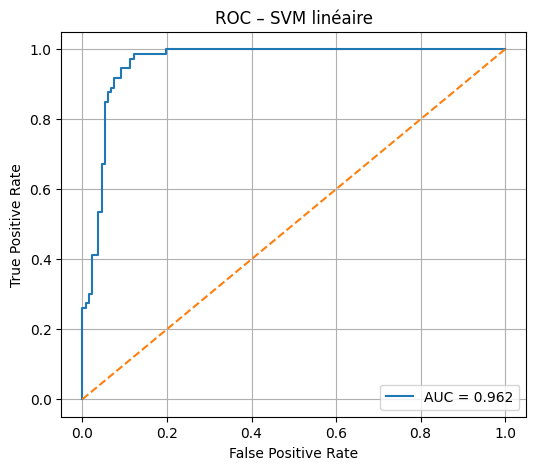

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test_proba = svm_linear.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – SVM linéaire")
plt.legend()
plt.grid(True)
plt.show()


# Modèle SVM RBF + GridSearch

Un second modèle a été entraîné à l’aide d’un SVM à noyau RBF afin de capturer d’éventuelles relations non linéaires entre les variables explicatives et la variable cible. Une recherche d’hyperparamètres par validation croisée stratifiée (5 plis) a été effectuée sur les paramètres C et gamma à l’aide de GridSearchCV, en optimisant la métrique F1-score.

## Résultats quantitatif

- Cependant, malgré cette très bonne AUC, les performances effectives en classification binaire restent limitées par un mauvais compromis précision-rappel, ce qui illustre qu’une bonne AUC ne garantit pas nécessairement une performance optimale au seuil de décision par défaut.

**Comparaison SVM linéaire** 

Le noyau RBF introduit une complexité excessive qui conduit à un sur-apprentissage, tandis que le modèle linéaire fournit un meilleur compromis entre biais et variance.

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1],
    "kernel": ["rbf"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    scoring="f1",      # ou "roc_auc"
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Meilleurs paramètres :", grid.best_params_)
print("Score CV :", grid.best_score_)

best_svm = grid.best_estimator_

y_test_pred = best_svm.predict(X_test_scaled)

print("\nAccuracy TEST :", accuracy_score(y_test, y_test_pred))
print("\nClassification report (TEST):")
print(classification_report(y_test, y_test_pred))

Meilleurs paramètres : {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Score CV : 0.9664700927448274

Accuracy TEST : 0.8146341463414634

Classification report (TEST):
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       132
           1       0.66      1.00      0.79        73

    accuracy                           0.81       205
   macro avg       0.83      0.86      0.81       205
weighted avg       0.88      0.81      0.82       205



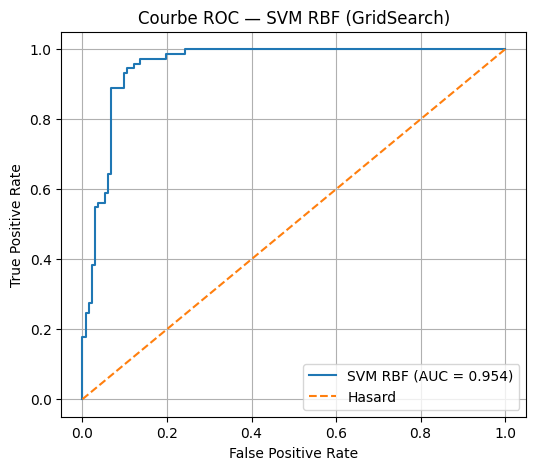

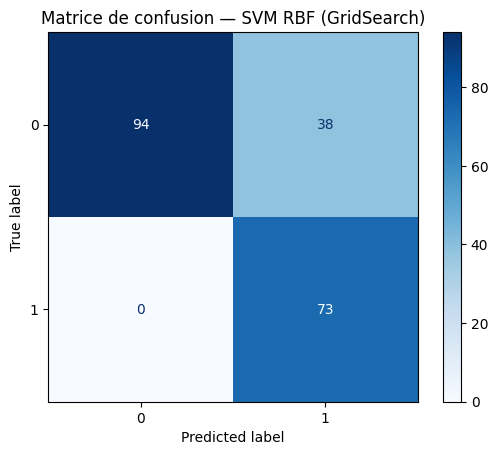

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# ==PROBABILITÉS POUR ROC =
y_test_proba = best_svm.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# == COURBE ROC ===
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"SVM RBF (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Hasard")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC — SVM RBF (GridSearch)")
plt.legend()
plt.grid(True)
plt.show()


# ====== MATRICE DE CONFUSION ======
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion — SVM RBF (GridSearch)")
plt.grid(False)
plt.show()
